## Install

In [2]:
!pip install pykeen[tensorboard]

  Using cached pykeen-1.10.2-py3-none-any.whl.metadata (83 kB)
  Using cached click_default_group-1.2.4-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
  Using cached more_click-0.1.2-py3-none-any.whl.metadata (4.3 kB)
  Using cached pystow-0.5.4-py3-none-any.whl.metadata (8.9 kB)
  Using cached docdata-0.0.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached class_resolver-0.4.3-py3-none-any.whl.metadata (13 kB)
  Using cached torch_max_mem-0.1.3-py3-none-any.whl.metadata (7.4 kB)
  Using cached torch_ppr-0.0.8-py3-none-any.whl.metadata (9.3 kB)
  Using cached alembic-1.13.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
Using cached class_resolver-0.4.3-py3-none-any.whl (25 kB)
Using cached optuna-3.6.1-py3-none-any.whl (380 kB)
Using cached pystow-0.5.4-py3-none-any.whl (32 kB)
Using cached torch_max_mem-0.1.3-

## Librerie

In [2]:
import json
import requests
import os
import pandas as pd
import numpy as np
import tarfile
import tqdm
from pykeen.pipeline import pipeline
from pykeen.predict import predict_all
import torch
from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import matplotlib.pyplot as plt

In [ ]:
#from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_most_clicked_reduced = pd.read_csv("data/df_most_clicked_reduced.csv")

## Graph Embedding

In [18]:
len(np.unique(df_most_clicked_reduced['head'])), len(np.unique(df_most_clicked_reduced['rel'])), len(np.unique(df_most_clicked_reduced['tail']))

(3635, 335, 2523)

In [19]:
triples = df_most_clicked_reduced[['head', 'rel', 'tail']].values
tf = TriplesFactory.from_labeled_triples(triples)

In [1]:
# Prepare to store the results
results_dict = {}

models_to_train = ['TransE', 'RotatE', 'ComplEx', 'QuatE']

for model_name in models_to_train:
    print(f"Training model: {model_name}")
    result = pipeline(
        model=model_name,
        training=tf,
        testing=tf,  # Using the dataset for both training and testing
        training_kwargs=dict(num_epochs=100, batch_size=256),
        random_seed=42,
        device='cuda'  # or 'cpu'
    )
    # Store the results
    results_dict[model_name] = result

Training model: TransE


NameError: name 'pipeline' is not defined

In [21]:
# Dictionary to collect metrics
metrics_dict = {
    'MR': [],
    'MRR': [],
    'Hits@1': [],
    'Hits@3': [],
    'Hits@10': []
}

# Extract metrics
for model_name, result in results_dict.items():
    metrics_dict['MR'].append(result.metric_results.get_metric('mean_rank'))
    metrics_dict['MRR'].append(result.metric_results.get_metric('mean_reciprocal_rank'))
    metrics_dict['Hits@1'].append(result.metric_results.get_metric('hits@1'))
    metrics_dict['Hits@3'].append(result.metric_results.get_metric('hits@3'))
    metrics_dict['Hits@10'].append(result.metric_results.get_metric('hits@10'))


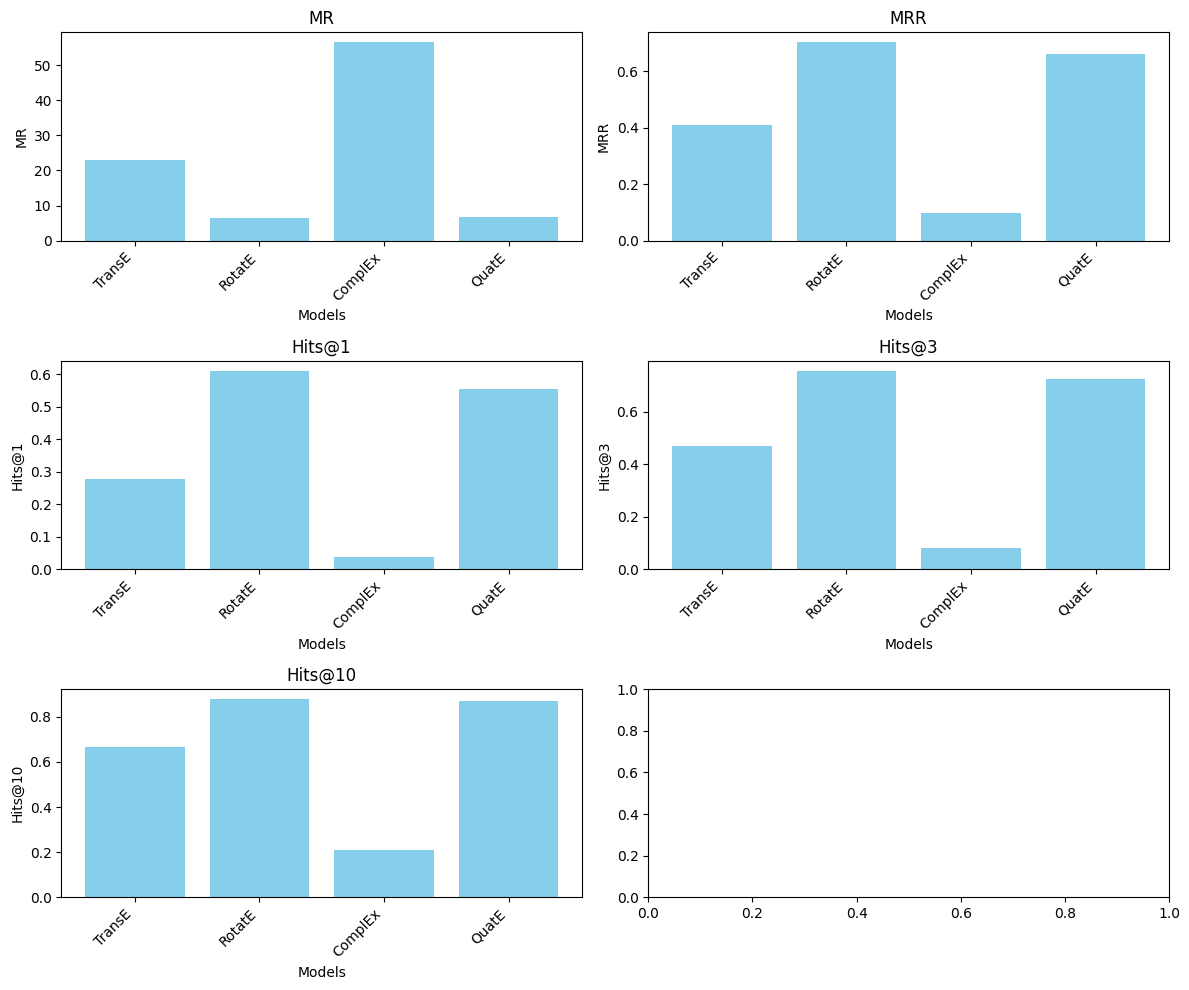

In [22]:
# Plot settings
fig, ax = plt.subplots(3, 2, figsize=(12, 10))  # Adjust subplot grid as needed
ax = ax.flatten()  # Flatten if you use a grid
metrics_keys = list(metrics_dict.keys())

# Plot each metric
for i, metric in enumerate(metrics_keys):
    ax[i].bar(models_to_train, metrics_dict[metric], color='skyblue')
    ax[i].set_title(metric)
    ax[i].set_ylabel(metric)
    ax[i].set_xlabel('Models')
    for label in ax[i].get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

# Adjust layout
plt.tight_layout()
plt.show()

In [31]:
# Directory where models will be saved
models_directory = 'drive/MyDrive/Models'
os.makedirs(models_directory, exist_ok=True)

In [32]:
for model_name in models_to_train:
    # Save the trained model to the designated directory
    model_save_path = os.path.join(models_directory, model_name + ".pkl")
    torch.save(results_dict[model_name].model, model_save_path)
    print(f"Model {model_name} saved to {model_save_path}")

Model TransE saved to drive/MyDrive/Models/TransE.pkl
Model RotatE saved to drive/MyDrive/Models/RotatE.pkl
Model ComplEx saved to drive/MyDrive/Models/ComplEx.pkl
Model QuatE saved to drive/MyDrive/Models/QuatE.pkl
